# **Libs**

In [1]:
# Работа с данными
import pandas as pd

# Torch
from torchvision import transforms, models
import segmentation_models_pytorch as smp

# Остальное
from sklearn.model_selection import train_test_split

# Utils
from image_segmentation.model import *

In [2]:
import warnings


warnings.simplefilter('ignore')

# **Code**

## Зафиксируем seed

In [3]:
set_all_seeds()

## Data

### **Transformation** and **augmentation**

In [4]:
# Определим базовые преобразования
image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),                      # Преобразовать в тензор
    #transforms.Normalize(mean=mean, std=std)    # Нормализовать данные
])
mask_transform = transforms.Compose([
    transforms.Resize(image_size),  # Изменение размера до 128x128
    transforms.ToTensor(),
])

# Определим преобразования с аугментациями
image_augmentation = transforms.Compose([
    image_transform
])

### Reading

In [5]:
from torchvision.datasets import OxfordIIITPet

In [6]:
train_dataset = OxfordIIITPet(
    root='./data',
    split='trainval',
    download=True,
    transform=image_transform,
    target_types='segmentation',
    target_transform=mask_transform
)

In [7]:
clas = label_encoding(train_dataset)

100%|██████████| 3680/3680 [00:44<00:00, 83.24it/s] 


In [8]:
dict_classes = {i: clas[i] for i in range(len(clas))}
dict_reverse = {clas[i]: i for i in range(len(clas))}

In [9]:
def map_labels(mask):
    mask = mask.numpy()  # Преобразуем тензор в numpy массив для удобства работы с индексами
    for old_label, new_label in dict_reverse.items():
        mask[mask == old_label] = new_label  # Заменяем старую метку на новую
    return torch.tensor(mask, dtype=torch.long)

In [10]:
device

'cuda'

In [11]:
mask_transform = transforms.Compose([
    transforms.Resize(image_size),  # Изменение размера до 128x128
    transforms.ToTensor(),
    map_labels,
])

In [12]:
train_data = OxfordIIITPet(
    root='./data',
    split='trainval',
    download=True,
    transform=image_transform,
    target_types='segmentation',
    target_transform=mask_transform,
)


test_data = OxfordIIITPet(
    root='./data',
    split='test',
    download=True,
    transform=image_transform,
    target_types='segmentation',
    target_transform=mask_transform
)

### Split and Create Datasets

In [13]:
train_set, valid_set = train_val_split(train_data, val_size=0.05)
train_set, _ = train_val_split(train_set, val_size=0.95)

### Visualization

In [14]:
def show_images(dataset, k=5):
    """
    Визуализация изображений и соответствующих масок из датасета.
    
    :param dataset: PyTorch Dataset, содержащий изображения и маски
    :param k: Количество изображений для визуализации
    """
    # Убедимся, что k не превышает длину датасета
    k = min(k, len(dataset))
    
    # Устанавливаем размер сетки
    fig, axs = plt.subplots(k, 2, figsize=(10, 5 * k))
    for i in range(k):
        # Получаем i-ый элемент из датасета
        print(dataset[i])
        image, mask = dataset[i]
        
        # Преобразуем изображения и маски в numpy (если это тензоры)
        if hasattr(image, 'numpy'):
            image = image.numpy()
        if hasattr(mask, 'numpy'):
            mask = mask.numpy()
        
        # Убираем канал, если он есть (для изображений с формой (1, H, W))
        if image.ndim == 3 and image.shape[0] == 1:
            image = image.squeeze(0)  # Убираем первый канал
        elif image.ndim == 3 and image.shape[0] == 3:
            image = image.transpose(1, 2, 0)  # Переставляем каналы (C, H, W) → (H, W, C)
        
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask.squeeze(0)  # Убираем первый канал
        
        # Отображаем изображение
        axs[i, 0].imshow(image, cmap='gray' if image.ndim == 2 else None)
        axs[i, 0].set_title(f"Image {i + 1}")
        axs[i, 0].axis("off")
        
        # Отображаем маску
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title(f"Mask {i + 1}")
        axs[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

(tensor([[[0.1412, 0.1412, 0.1451,  ..., 0.9922, 0.9843, 0.9765],
         [0.1451, 0.1490, 0.1373,  ..., 1.0000, 0.9961, 0.9922],
         [0.1529, 0.1804, 0.2353,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0196, 0.1765, 0.1765,  ..., 0.2431, 0.2275, 0.2392],
         [0.0196, 0.0471, 0.1647,  ..., 0.2353, 0.2314, 0.2275],
         [0.0314, 0.0314, 0.0353,  ..., 0.2275, 0.2392, 0.2431]],

        [[0.0745, 0.0745, 0.0745,  ..., 0.9882, 0.9843, 0.9765],
         [0.0745, 0.0784, 0.0706,  ..., 1.0000, 0.9961, 0.9922],
         [0.0824, 0.1020, 0.1373,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0353, 0.1804, 0.1843,  ..., 0.4118, 0.3608, 0.3569],
         [0.0314, 0.0549, 0.1686,  ..., 0.3843, 0.3922, 0.3529],
         [0.0353, 0.0392, 0.0431,  ..., 0.3490, 0.3882, 0.4000]],

        [[0.0431, 0.0431, 0.0471,  ..., 0.9961, 0.9922, 0.9922],
         [0.0471, 0.0471, 0.0392,  ..., 1.0000, 0.9961, 0.9961],
         [0.0510, 0.0549, 0.0667,  ..., 1.0000, 1.0000, 1

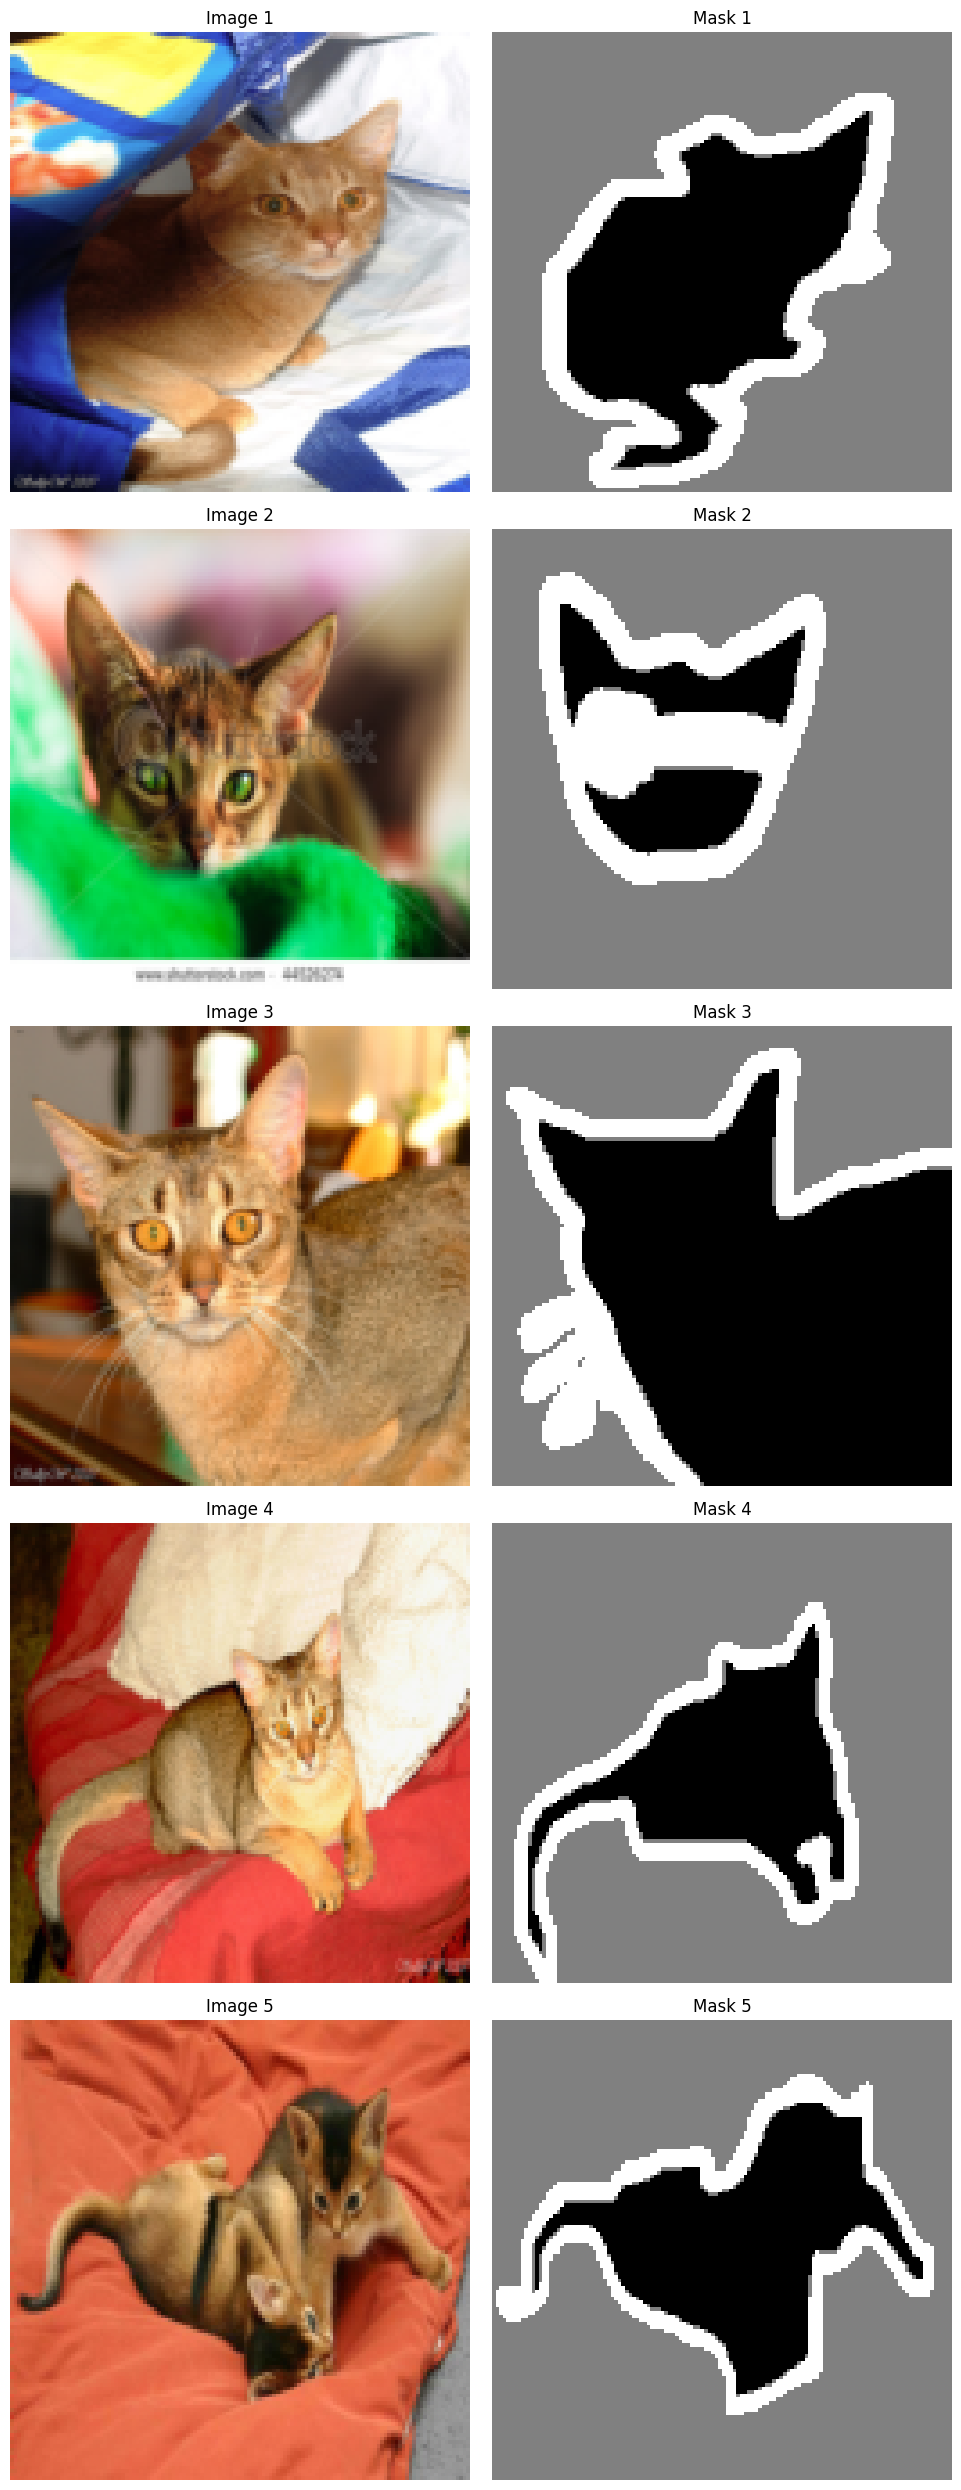

In [15]:
show_images(train_data, k=5)

### Creating a DataLoader

In [16]:
# Создание DataLoader для каждой выборки
batch_size = 24

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

## Models

In [17]:
# Список моделей
models = [
    "Unet",
    "FPN",
    "PSPNet",
    "DeepLabV3",
    "Linknet",
    "PanopticFPN",
    "MAnet",
    "TransUNet",
    "Unet++"
]

# Список энкодеров
encoders = [
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "resnext50_32x4d", "resnext101_32x8d", "wide_resnet50_2", "wide_resnet101_2",
    "efficientnet-b0", "efficientnet-b1", "efficientnet-b2", "efficientnet-b3", "efficientnet-b4", 
    "efficientnet-b5", "efficientnet-b6", "efficientnet-b7",
    "vgg11", "vgg11_bn", "vgg13", "vgg13_bn", "vgg16", "vgg16_bn", "vgg19", "vgg19_bn",
    "inceptionv3",
    "densenet121", "densenet169", "densenet201", "densenet161",
    "mobilenet_v2",
    "inceptionresnetv2",
    "seresnet18", "seresnet34", "seresnet50", "seresnet101", "seresnet152",
    "regnetx_002", "regnetx_004", "regnetx_006", "regnetx_008", "regnetx_016", 
    "regnetx_032", "regnetx_040", "regnetx_064",
    "vit_b_16", "vit_b_32", "vit_l_16", "vit_l_32", "vit_h_14",
    "convnext_tiny", "convnext_small", "convnext_base", "convnext_large"
]

# Список доступных весов
weights = [
    "imagenet",    # Используем веса предобученные на ImageNet
    "noisy-student",  # Веса для моделей обученных с noisy student
    None          # Без предобученных весов
]

### Score

In [18]:
scores = dict()

### Unet

In [19]:
model = smp.Unet(
    encoder_name="resnet34",        # Предобученный энкодер ResNet34
    encoder_weights="imagenet",     # Используем предобученные веса
    in_channels=3,                  # Количество каналов входного изображения (RGB)
    classes=len(clas)                       # Количество классов (фон, силуэт, кошка)
)

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def f1_macro(output, target):
    f1 = f1_score(target, output, average='macro')
    return f1

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
unet = ImageSegmentation(model, loss_fn=loss_fn, metric=f1_macro, name="UNet")

In [ ]:
unet.fit(train_loader, valid_loader, 10)
scores[unet.best_score] = unet

Epoch: 1/10 (total: 1)

Loss: CrossEntropyLoss
 - Train: 1.0193
 - Valid: 2.3874

Score: f1_macro
 - Train: 0.4254
 - Valid: 0.2478

(Model saved)
Model for epoch 1 saved at ./models\UNet\epochs\epoch_1.pth

Epoch: 2/10 (total: 2)



Training:  50%|█████     | 4/8 [00:06<00:06,  1.52s/it, CrossEntropyLoss=0.8036, f1_macro=0.5810]



Training прервано пользователем. Завершаем текущую эпоху...


Evaluating:  75%|███████▌  | 6/8 [00:08<00:03,  1.64s/it, CrossEntropyLoss=1.2121, f1_macro=0.4899]

### Unet (18)

In [32]:
model18 = smp.Unet(
    encoder_name="resnet18",        # Предобученный энкодер ResNet34
    encoder_weights="imagenet",     # Используем предобученные веса
    in_channels=3,                  # Количество каналов входного изображения (RGB)
    classes=len(clas)                       # Количество классов (фон, силуэт, кошка)
)
loss_fn18 = torch.nn.CrossEntropyLoss()

In [33]:
unet18 = ImageSegmentation(model18, loss_fn=loss_fn18, metric=f1_macro, name="UNet18")

Epoch: 10/10 (total: 10)

Loss: CrossEntropyLoss
 - Train: 0.3104
 - Valid: 0.4228

Score: f1_macro
 - Train: 0.8342
 - Valid: 0.7624

Model for epoch 10 saved at ./models\UNet18\epochs\epoch_10.pth


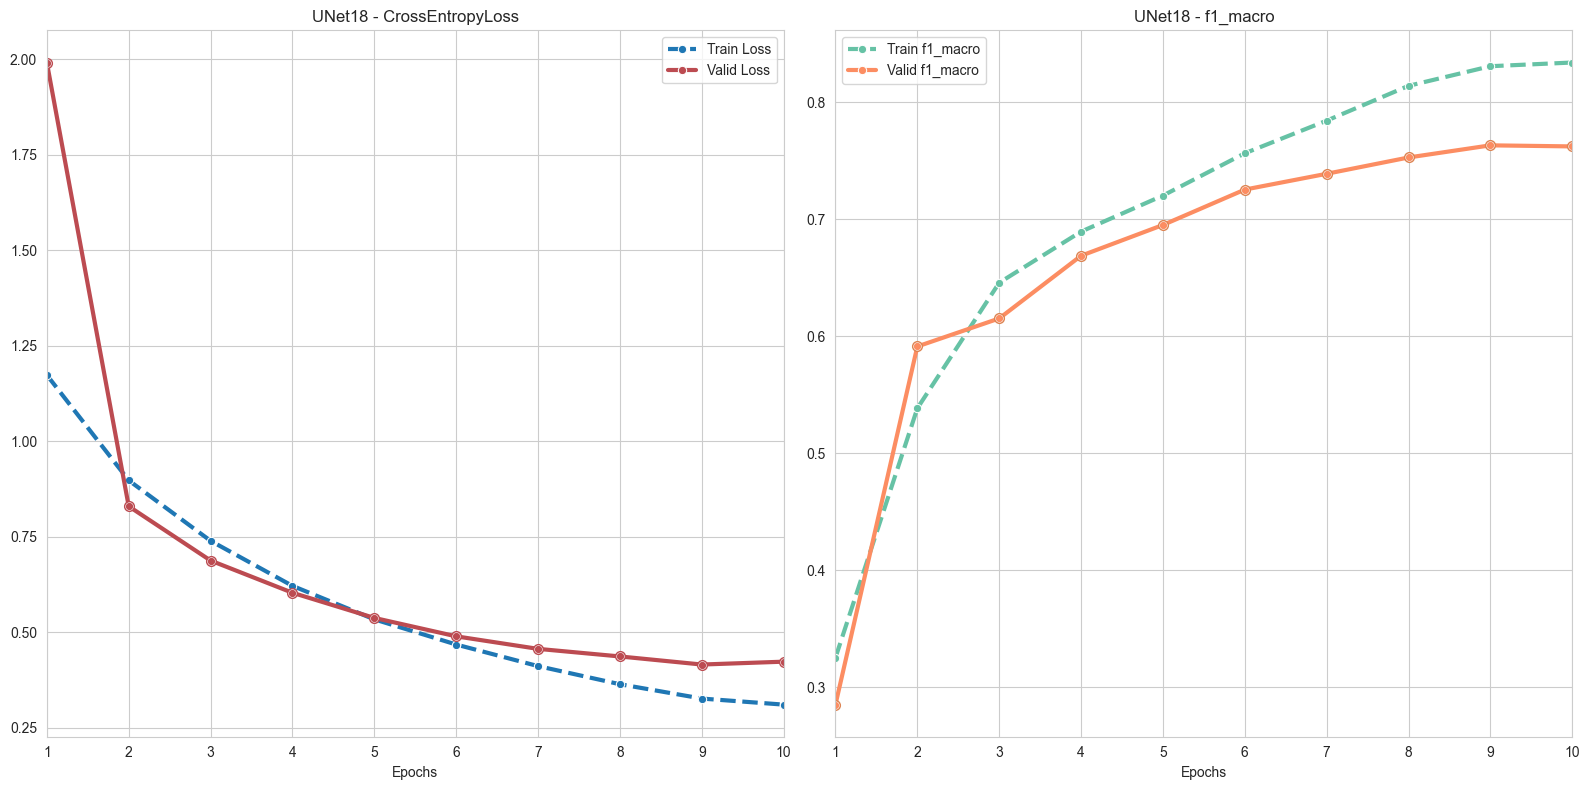

Best valid score: 0.7633 (9 epoch)

Training history saved at ./models\UNet18\training_history.csv


In [34]:
unet18.fit(train_loader, valid_loader, 10)
scores[unet18.best_score] = unet18

## Result

In [24]:
best_model = scores[max(scores)] # ? Выбрать модель
best_model.name

'UNet'

In [ ]:
# Количество изображений для отображения
n = 3

# Создание фигуры для вывода нескольких наборов изображений
fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
fig.patch.set_alpha(0.0)  # Прозрачный фон

for i, idx in enumerate(random.sample(range(len(valid_set)), n)):
    # Извлечение данных и предсказания
    image, label = valid_set[idx]  # Предполагается, что valid_set возвращает (изображение, маска)
    prediction = best_model.predict(image.unsqueeze(0))  # Предсказание для одного изображения
    prediction = prediction.squeeze(0)  # Убираем размерность батча

    # Денормализация изображения
    image_np = denormalize(image).cpu().numpy().transpose(1, 2, 0)  # Перестановка для отображения

    # Преобразование данных в формат NumPy
    label_np = label.cpu().numpy()  # Истинная маска
    prediction_np = prediction.cpu().numpy()  # Предсказанная маска

    # Отображение изображения
    axes[i, 0].imshow(image_np)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Image", fontsize=12, color='white')

    # Отображение истинной маски
    axes[i, 1].imshow(label_np, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("True Mask", fontsize=12, color='white')

    # Отображение предсказанной маски
    axes[i, 2].imshow(prediction_np, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Predicted Mask", fontsize=12, color='white')

# Общий показ фигуры
plt.tight_layout()
plt.show()


## Submission

In [ ]:
test_image_names = list(map(lambda path: f"../data/test_images/{path}", os.listdir("../data/test_images")))
test_set = ImageDataset(test_image_names, transform=image_transform)

In [ ]:
predict_class_id = best_model.predict(test_set)
predict_class_names = [classes[class_id] for class_id in predict_class_id]